Import libraries and useful functions. Code reused from week 4 exercises.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

Load the CIFAR-10 dataset and split it into train and test sets.

In [3]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

In [4]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


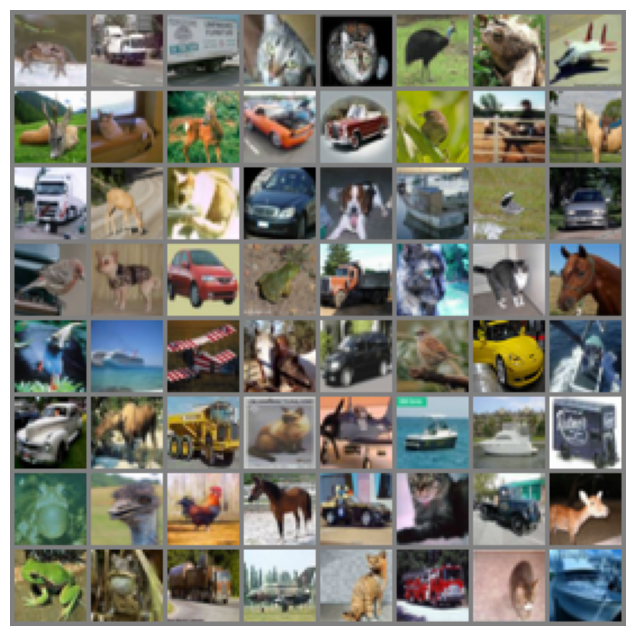

In [5]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

Define model architecture and forward pass of CNN.

In [6]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.activation_fn = nn.ReLU

        self.net = nn.Sequential(
            # CNN
            nn.Conv2d(3, 32, 5),
            self.activation_fn(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            self.activation_fn(),
            nn.MaxPool2d(2),
            #nn.Dropout(0.2),

            nn.Flatten(),

            # FFNN
            nn.LazyLinear(128),
            self.activation_fn(),
            nn.Linear(128, 128),
            self.activation_fn(),
            nn.Linear(128, 128),
            self.activation_fn(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)
    


model = Model(n_classes)
device = torch.device('cpu')  
model.to(device)
print(model)

Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=128, bias=True)
    (12): ReLU()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


Define loss function and optimizers.

In [7]:
loss_fn = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-3)  

Train the model.

In [8]:
num_epochs = 8
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.

        # Compute outputs
        output = model(inputs)

        # Compute loss
        loss = loss_fn(output, targets)

        # Zero gradients
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # One step of gradient descent
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        # Validate every `validation_every_steps` steps.
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.39965625
             validation accuracy: 0.5096
Step 1000    training accuracy: 0.5713876146788991
             validation accuracy: 0.5973
Step 1500    training accuracy: 0.6184375
             validation accuracy: 0.6387
Step 2000    training accuracy: 0.6675028669724771
             validation accuracy: 0.6737
Step 2500    training accuracy: 0.7274756493506493
             validation accuracy: 0.6783
Step 3000    training accuracy: 0.719375
             validation accuracy: 0.6907
Step 3500    training accuracy: 0.7566364247311828
             validation accuracy: 0.6994
Step 4000    training accuracy: 0.7972222222222223
             validation accuracy: 0.7029
Step 4500    training accuracy: 0.784875
             validation accuracy: 0.7039
Step 5000    training accuracy: 0.8218344155844156
             validation accuracy: 0.6982
Step 5500    training accuracy: 0.8365384615384616
             validation accuracy: 0.7117
Step 6000    training acc

Evaluate model performance on test set.

In [14]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)

        probs = torch.softmax(output, dim=1)
        print(probs[0])
        print(targets[0])

        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()

print(f"Test accuracy: {test_accuracy:.3f}")

tensor([1.9735e-05, 5.1070e-06, 1.5195e-03, 8.0184e-01, 1.7731e-03, 1.8946e-01,
        5.1427e-03, 2.4371e-04, 8.2700e-07, 3.5044e-06])
tensor(3)
tensor([1.8098e-05, 1.1015e-04, 1.4239e-02, 2.6096e-02, 6.1463e-04, 3.0563e-02,
        9.2811e-01, 1.6430e-04, 6.9923e-05, 1.5785e-05])
tensor(6)
tensor([1.0167e-02, 4.4619e-03, 7.4991e-03, 5.4722e-01, 7.2764e-03, 3.1918e-01,
        1.0236e-01, 1.3676e-03, 1.4706e-05, 4.5427e-04])
tensor(5)
tensor([0.6733, 0.0023, 0.1101, 0.1349, 0.0179, 0.0246, 0.0050, 0.0206, 0.0031,
        0.0082])
tensor(0)
tensor([9.6980e-07, 1.0875e-05, 1.0154e-03, 1.7091e-02, 9.1803e-05, 8.8782e-04,
        9.8089e-01, 1.1940e-06, 5.9572e-06, 6.0159e-07])
tensor(3)
tensor([4.7306e-05, 7.7106e-06, 1.2668e-02, 4.4156e-01, 2.1228e-02, 5.1631e-01,
        4.7292e-03, 3.4376e-03, 2.1783e-06, 4.1027e-06])
tensor(3)
tensor([1.1853e-04, 6.4298e-05, 2.4324e-02, 1.4632e-01, 6.8375e-02, 7.4163e-01,
        4.8407e-03, 1.4226e-02, 5.7377e-05, 4.5416e-05])
tensor(2)
tensor([2.9

Plot confusion matrix for test set.

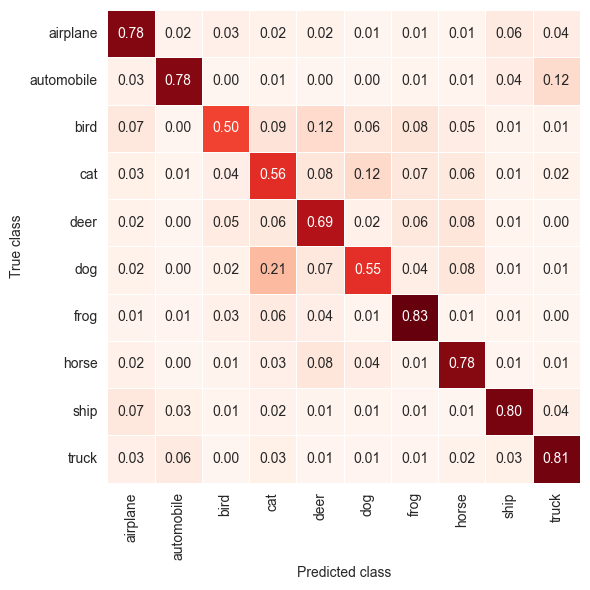

In [40]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Plot per class accuracy of predictions.

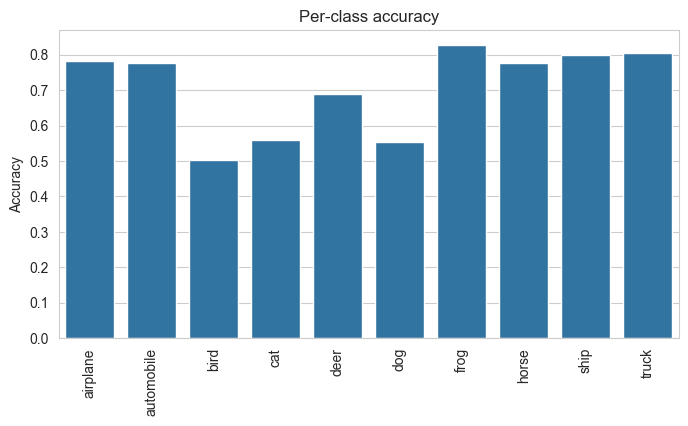

In [41]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
def conformal_prediction():
    